In [13]:
import pandas as pd
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch
import torchvision
import torchvision.transforms as transforms

import helpers
CONFIG = helpers.get_config()

In [14]:
torch.cuda.is_available()

False

In [4]:
sys.path.insert(0, '../helpers/')

from data_loader import Cxr8ImageDatasetLoader
from model_pipeline import Cxr8Net
# from preprocessing_pipeline import Cxr8PreProcessor

In [5]:
net = Cxr8Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-03)

In [6]:
# transformer = Cxr8PreProcessor()
transformer = None
target_transformer = None

In [7]:
trainset = Cxr8ImageDatasetLoader(CONFIG['TRAIN_IMAGES'], CONFIG['FLATTENED_FOLDER'], transformer, target_transformer)
testset = Cxr8ImageDatasetLoader(CONFIG['TEST_IMAGES'], CONFIG['FLATTENED_FOLDER'], transformer, target_transformer)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=CONFIG['BATCH_SIZE'], shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=CONFIG['BATCH_SIZE'], shuffle=True, num_workers=2)

classes = pd.read_csv(CONFIG['TRAIN_IMAGES'], header=None)[1].unique()
classes

array(['Cardiomegaly', 'No Finding', 'Infiltration', 'Nodule',
       'Emphysema', 'Effusion', 'Atelectasis', 'Pleural_Thickening',
       'Fibrosis', 'Mass', 'Pneumonia', 'Pneumothorax', 'Hernia',
       'Consolidation', 'Edema'], dtype=object)

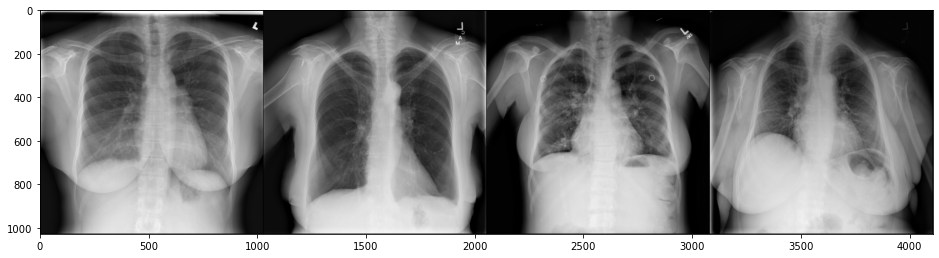

Labels: ('No Finding', 'Atelectasis', 'Infiltration', 'No Finding')


In [11]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

plt.figure(figsize=(16,5))
imshow(torchvision.utils.make_grid(images))

print(f'Labels: {labels}')

In [ ]:
def single_epoch(index, writer):
        running_loss = 0.
        last_loss = 0.

        for i, data in enumerate(trainloader, 0):

            inputs, labels = data

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 1000 == 999:
                last_loss = running_loss / 1000
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 1000:.3f}')
                tb_x = index * len(trainloader) + i + 1
                writer.add_scalar('Loss/train', last_loss, tb_x)
                running_loss = 0.0

            return last_loss

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

epoch_number = 0
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))

for epoch in range(CONFIG['EPOCHS']):
    print('EPOCH {}:'.format(epoch_number + 1))

    net.train(True)
    avg_loss = single_epoch(epoch_number, writer)
    net.train(False)

    running_loss = 0.0
    for i, data in enumerate(testloader):
        inputs, labels = data
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        running_loss

    avg_vloss = running_loss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    writer.add_scalars('Training vs. Validation Loss',
                       { 'Training' : avg_loss, 'Validation' : avg_vloss },
                       epoch_number + 1)
    writer.flush()

    if best_loss is None:
        best_loss = avg_loss

    if avg_vloss < best_loss:
        best_vloss = avg_vloss
        model_path = CONFIG['CHECKPOINTS_FOLDER'] + 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(net.state_dict(), model_path)

    epoch_number += 1


In [ ]:
# load optimal model